In [2]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

c:\Users\markham\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
test_data = pd.read_csv('data\processed_articles_V8.csv')
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data['content'] = test_data['content'].apply(lambda x: ' '.join(x.split(',')))
test_data

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\markham\AppData\Local\Temp\ipykernel_3432\1635909924.py:1: SyntaxWarning: invalid escape sequence '\p'
  test_data = pd.read_csv('data\processed_articles_V8.csv')


,date,content
653,2018-12-31,mattis exit tell military keep faith countrywa...
571,2018-12-31,democrats manoeuvre end shutdown trump wall mo...
544,2018-12-31,frenchman nasri complete west ham move doping ...
5,2018-12-31,russian apartment block blast kill three dozen...
609,2018-12-31,wall street rise limp finish line turbulent ye...
...,...,...
1837,2019-01-31,south korea kdb sign deal hyundai heavy daewoo...
1838,2019-01-31,fifth asian cup title would major step japan y...
1839,2019-01-31,mediacoal india talk gail ioc coal bed methane...
1833,2019-01-31,modi see appease voter put reform aside budget...


In [4]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words_list = [ 'china','usa','us','america','american','americans','chinese','china','russia','russian','putin','vladimir','trump','donald','biden','joe','ukraine','ukrainian','ukrainians','ukraines','ukraine','say','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','mon','tue','wed','thu','fri','sat','sun','monday','tuesday','wednesday','thursday','friday','saturday','sunday','january','february','march','april','may','june','july','august','september','october','november','december','today','yesterday','tomorrow','week','month','year','time','day','weekend','morning','afternoon','evening','night','news','new','news']
list_numbers = ['one','two','three','four','five','six','seven','eight','nine','ten','hundred','thousand','million','billion','trillion']
stop_words.update(stop_words_list)
stop_words.update(list_numbers)
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word != 'nan']))

In [9]:
import pandas as pd
import numpy as np
from gensim.models import FastText
from sklearn.cluster import KMeans

# 假设 test_data['content'] 是分词后的单词列表
# 示例：test_data['content'] = [['the', 'economy', 'is', 'booming'], ['a', 'tragic', 'event', 'occurred']]

# 训练 FastText 模型
model = FastText(sentences=test_data['content'], vector_size=100, window=5, min_count=1, workers=4)

# 定义函数，将分词列表转换为向量
def text_to_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 将每条新闻转换为向量
test_data['vector'] = test_data['content'].apply(lambda x: text_to_vector(x, model))

# 提取所有新闻的向量数据
X = np.array(test_data['vector'].tolist())

# 假设聚类数量为 2
num_clusters = 2

# 使用 K-means 聚类
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# 将聚类标签添加到原数据中
test_data['cluster_label'] = labels

# 查看结果
test_data


,date,content,vector,cluster_label
653,2018-12-31,mattis exit tell military keep faith countrywa...,"[-0.069570035, 0.054303993, 0.0030600298, 0.03...",1
571,2018-12-31,democrats manoeuvre end shutdown wall moneywas...,"[-0.07130776, 0.057401475, 0.0059061167, 0.039...",1
544,2018-12-31,frenchman nasri complete west ham move doping ...,"[-0.053368963, 0.049776793, 0.01150572, 0.0386...",0
5,2018-12-31,apartment block blast kill dozen miss agencymo...,"[-0.062699236, 0.057670116, 0.010531948, 0.029...",0
609,2018-12-31,wall street rise limp finish line turbulent ye...,"[-0.065131746, 0.057301305, 0.00829678, 0.0366...",1
...,...,...,...,...
1837,2019-01-31,south korea kdb sign deal hyundai heavy daewoo...,"[-0.081875384, 0.05222515, 0.016936159, 0.0325...",0
1838,2019-01-31,fifth asian cup title would major step japan y...,"[-0.061243072, 0.04275566, 0.0018797452, 0.039...",0
1839,2019-01-31,mediacoal india talk gail ioc coal bed methane...,"[-0.04059205, 0.042498775, 0.008747263, 0.0594...",0
1833,2019-01-31,modi see appease voter put reform aside budget...,"[-0.07232466, 0.057946794, 0.007731281, 0.0367...",1


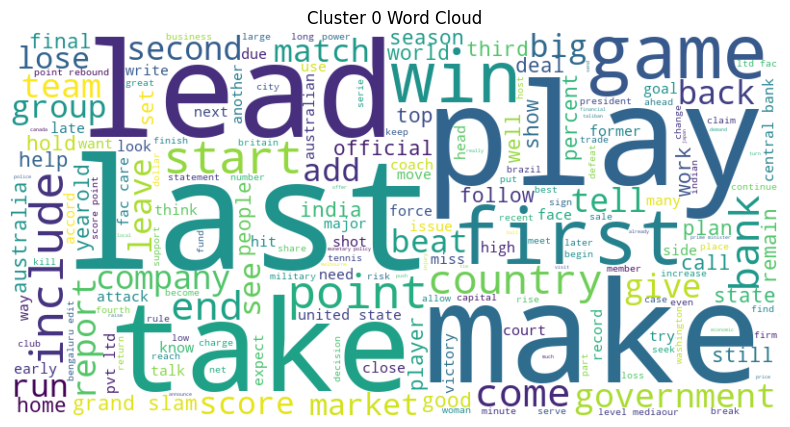

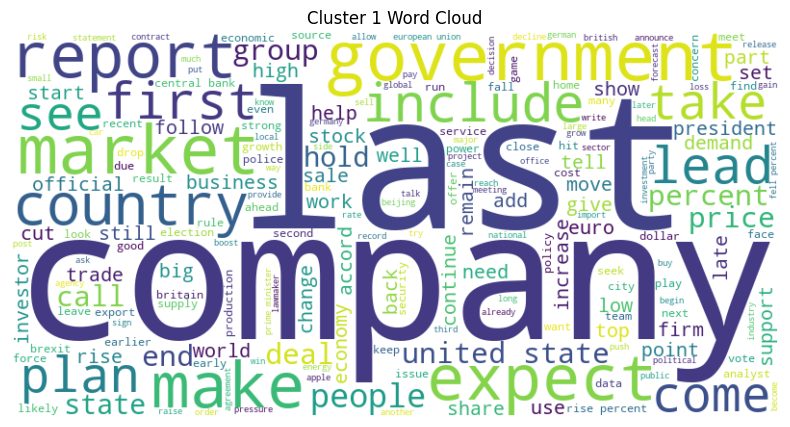

In [10]:
# 定义一个函数来生成词云
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 获取每个聚类的高频词
for cluster in range(num_clusters):
    # 将属于同一聚类的文本合并为一个字符串
    cluster_text = ' '.join(test_data[test_data['cluster_label'] == cluster]['content'])
    plot_word_cloud(cluster_text, f'Cluster {cluster} Word Cloud')

In [11]:
# 评估聚类效果
if len(set(labels)) > 1:
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"轮廓系数: {silhouette}")
    print(f"Calinski - Harabasz 指数: {ch_score}")
else:
    print("由于簇的数量不大于 1，无法计算聚类评估指标。")


轮廓系数: 0.14573770761489868
Calinski - Harabasz 指数: 478.26458110905105


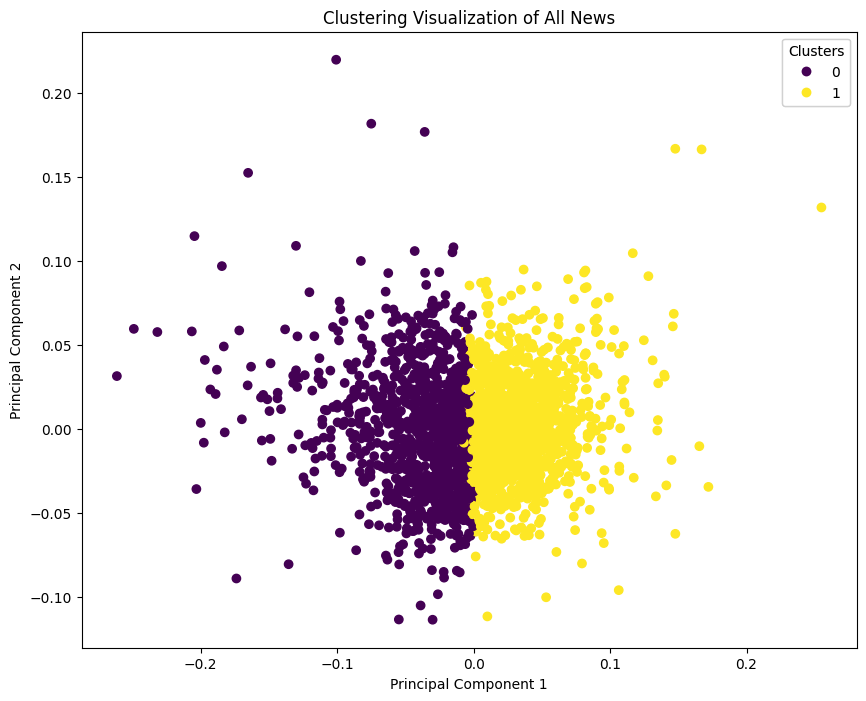

In [12]:
# 使用 PCA 将数据降到二维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 绘制散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)
plt.title('Clustering Visualization of All News')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [78]:


# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])
# 按日期分组
grouped = test_data.groupby('date')

# 加载 DistilBERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# 存储每天每个聚类的情感指数结果
sentiment_results = []

# 将模型移到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        
        for content in cluster_data['content']:
            # 如果 content 是列表，将其转换为字符串
            if isinstance(content, list):
                text = " ".join(str(item) for item in content)
            else:
                text = str(content)
                
            try:
                # 编码文本，设置最大长度为 512
                inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                                 padding=True, max_length=512)
                # 将输入移到相同的设备
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # 获取模型输出
                with torch.no_grad():
                    outputs = model(**inputs)
                
                # 处理预测结果
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                
                # DistilBERT SST-2 的标签顺序：negative [0], positive [1]
                positive_prob = probabilities[0][1].item()
                negative_prob = probabilities[0][0].item()
                
                # 计算情感得分：积极概率 - 消极概率
                sentiment_score = positive_prob - negative_prob
                sentiment_scores.append(sentiment_score)
                
            except Exception as e:
                print(f"处理文本时出错: {text[:50]}...，错误信息: {e}")
                continue
        
        # 计算平均情感得分
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
            'sentiment_score': average_sentiment,
            'num_samples': len(sentiment_scores)  # 添加样本数，便于检查
        })

# 创建 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# 打印结果
print(sentiment_df)

         date  cluster  sentiment_score  num_samples
0  2018-12-31        0        -0.994873            4
1  2018-12-31        1        -0.916606            2
2  2018-12-31        2        -0.560042            2
3  2019-01-01        0        -0.765207           34
4  2019-01-01        1        -0.775163           37
..        ...      ...              ...          ...
91 2019-01-30        1        -0.835802           30
92 2019-01-30        2        -0.674563           29
93 2019-01-31        0        -0.903579           26
94 2019-01-31        1        -0.878291           18
95 2019-01-31        2        -0.703057           22

[96 rows x 4 columns]


In [13]:
# change the sentiment method and use VADER
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])
# 按日期分组
grouped = test_data.groupby('date')

# 初始化VADER
analyzer = SentimentIntensityAnalyzer()

# 存储每天每个聚类的情感指数结果
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        
        for content in cluster_data['content']:
            # 如果 content 是列表，将其转换为字符串
            if isinstance(content, list):
                text = " ".join(str(item) for item in content)
            else:
                text = str(content)
            
            try:
                # 使用VADER计算情绪得分
                sentiment = analyzer.polarity_scores(text)
                compound_score = sentiment['compound']  # 综合得分作为情绪得分
                sentiment_scores.append(compound_score)
            except Exception as e:
                print(f"处理文本时出错: {text[:50]}...，错误信息: {e}")
                continue
        
        # 计算平均情感得分
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
            'sentiment_score': average_sentiment,
            'num_samples': len(sentiment_scores)  # 添加样本数，便于检查
        })

# 创建 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# 打印结果
print(sentiment_df)

         date  cluster  sentiment_score  num_samples
0  2018-12-31        0        -0.337133            3
1  2018-12-31        1         0.221140            5
2  2019-01-01        0         0.430552           63
3  2019-01-01        1         0.041155           49
4  2019-01-02        0         0.103170          114
..        ...      ...              ...          ...
59 2019-01-29        1         0.026898           45
60 2019-01-30        0         0.177933           36
61 2019-01-30        1         0.122318           50
62 2019-01-31        0         0.388157           28
63 2019-01-31        1         0.416029           38

[64 rows x 4 columns]


In [86]:
# Use BERT
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])

# 按日期分组
grouped = test_data.groupby('date')

# 加载 BERT 模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# 存储每天每个聚类的情感指数结果
sentiment_results = []

# 将模型移到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        
        for content in cluster_data['content']:
            # 如果 content 是列表，将其转换为字符串
            if isinstance(content, list):
                text = " ".join(str(item) for item in content)
            else:
                text = str(content)
                
            try:
                # 编码文本，设置最大长度为 512
                inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                                 padding=True, max_length=512)
                # 将输入移到相同的设备
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # 获取模型输出
                with torch.no_grad():
                    outputs = model(**inputs)
                
                # 处理预测结果
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                
                # BERT 的标签顺序：negative [0], positive [1]（假设，未微调时需确认）
                positive_prob = probabilities[0][1].item()
                negative_prob = probabilities[0][0].item()
                
                # 计算情感得分：积极概率 - 消极概率
                sentiment_score = positive_prob - negative_prob
                sentiment_scores.append(sentiment_score)
                
            except Exception as e:
                print(f"处理文本时出错: {text[:50]}...，错误信息: {e}")
                continue
        
        # 计算平均情感得分
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
            'sentiment_score': average_sentiment,
            'num_samples': len(sentiment_scores)  # 添加样本数，便于检查
        })

# 创建 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# 打印结果
print(sentiment_df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\markham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\markham\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


         date  cluster  sentiment_score  num_samples
0  2018-12-31        0        -0.291154            4
1  2018-12-31        1        -0.292447            2
2  2018-12-31        2        -0.234811            2
3  2019-01-01        0        -0.276623           34
4  2019-01-01        1        -0.252686           37
..        ...      ...              ...          ...
91 2019-01-30        1        -0.253232           30
92 2019-01-30        2        -0.243740           29
93 2019-01-31        0        -0.258423           26
94 2019-01-31        1        -0.251599           18
95 2019-01-31        2        -0.248437           22

[96 rows x 4 columns]
